# Clasificación de Hojas de Café

### Cargar las anotaciones del dataset

In [1]:
import json

annotations_file="RoCoLe.json"

with open(annotations_file,'r') as f:
    annotations=json.load(f)

### Dimensión del dataset

In [2]:
len(annotations)

1560

### Esquema de las anotaciones

In [3]:
annotations[2]

{'ID': 'cjvnf89dsfy900795gjew8qoj',
 'DataRow ID': 'cjvnehagg0jhz0ctnfqe98wpe',
 'Labeled Data': 'https://storage.googleapis.com/labelbox-193903.appspot.com/cjs5g735orqbe0b29ip8a1k1s%2F2b0c3fb0-23cf-d5ab-3e8f-b2ff6dad1120-C1P2H1.jpg',
 'Label': {'Leaf': [{'state': 'healthy',
    'geometry': [{'x': 15, 'y': 505},
     {'x': 114, 'y': 489},
     {'x': 390, 'y': 391},
     {'x': 516, 'y': 358},
     {'x': 705, 'y': 308},
     {'x': 886, 'y': 278},
     {'x': 1001, 'y': 280},
     {'x': 1150, 'y': 326},
     {'x': 1304, 'y': 379},
     {'x': 1383, 'y': 441},
     {'x': 1408, 'y': 482},
     {'x': 1481, 'y': 533},
     {'x': 1548, 'y': 521},
     {'x': 1484, 'y': 563},
     {'x': 1429, 'y': 606},
     {'x': 1422, 'y': 650},
     {'x': 1387, 'y': 684},
     {'x': 1281, 'y': 744},
     {'x': 1162, 'y': 795},
     {'x': 1107, 'y': 795},
     {'x': 1033, 'y': 813},
     {'x': 960, 'y': 804},
     {'x': 891, 'y': 813},
     {'x': 794, 'y': 808},
     {'x': 723, 'y': 774},
     {'x': 562, 'y': 74

### Crear una clase que contenga la información de las hojas

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


class CoffeeLeaf:    
    def __init__(self, leaf_id, state, classification, image_bgr, geometry):
        self.id = leaf_id
        self.state_manual = state
        self.state_computed = None
        self.classification_manual = classification
        self.classification_computed = None
        self.image_bgr = image_bgr
        self.image_rgb = None
        self.roi_rgb = None
        self.roi_hue = None
        self.mask = None
        self.area = None
        self.affected_percentage = None
        self.masked_roi_rgb = None
        self.masked_roi_hue = None
        self.histogram_hue = None
        self.binary = None
        self.contours = None
        self.polygon = None
        self.geometry = geometry
        self._generate_image_rgb()
        self._create_polygon()
        self._create_roi()
        self._create_mask()
        self._create_masked_roi()
        self._compute_histogram()
        self._binarize()
        self._find_contours()
        self._categorize()

    def _generate_image_rgb(self):
        self.image_rgb = cv.cvtColor(self.image_bgr, cv.COLOR_BGR2RGB)

    def _create_polygon(self):
        polygon_points = [list(point.values()) for point in self.geometry]
        self.polygon = np.array(polygon_points)

    def _create_roi(self):
        x,y,w,h = cv.boundingRect(self.polygon)
        self.roi_rgb = self.image_rgb[y:y+h, x:x+w].copy()
        self.roi_hsv = cv.cvtColor(self.roi_rgb, cv.COLOR_RGB2HSV)

    def _create_mask(self):
        self.mask = np.zeros(self.roi_hsv.shape[:2], np.uint8)
        polygon_start = self.polygon.min(axis=0)
        polygon_at_zero = self.polygon-polygon_start
        CONTOURS = -1 # All contours
        COLOR = (255, 255, 255) # White
        THICKNESS = -1 # Fill
        self.mask = cv.drawContours(self.mask, [polygon_at_zero], CONTOURS, COLOR, THICKNESS)
        self.area = cv.countNonZero(self.mask)

    def _create_masked_roi(self):
        self.masked_roi_rgb = cv.bitwise_and(self.roi_rgb, self.roi_rgb, mask=self.mask)
        self.masked_roi_hue = cv.bitwise_and(self.roi_hsv[:,:,0], self.mask)
        self.area = cv.countNonZero(self.mask)

    def _compute_histogram(self):
        hsv_normalizer = Normalize(vmin=0, vmax=255)
        self.hsv_mappable = ScalarMappable(norm=hsv_normalizer, cmap='hsv')
        self.histogram_hue = cv.calcHist([self.masked_roi_hue], [0], self.mask, [256], [0,256])

    def _binarize(self):
        HUE_HEALTHY_LIMIT = 30
        thresh, self.binary = cv.threshold(self.masked_roi_hue, HUE_HEALTHY_LIMIT, 255, cv.THRESH_BINARY)

    def _find_contours(self):
        contours, hierarchy = cv.findContours(self.masked_roi_hue, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        self.contours = np.ones(self.mask.shape, np.uint8)
        CONTOURS = -1 # All contours
        COLOR = (0, 0, 0) # Black
        THICKNESS = -1 # Fill
        cv.drawContours(self.contours, contours, CONTOURS, COLOR)

    def _categorize(self):
        healthy_area = cv.countNonZero(self.binary)
        affected_area = self.area-healthy_area
        self.affected_percentage = affected_area*100/self.area

        if self.affected_percentage < 1:
            self.state_computed = "healthy"
            self.classification_computed = "healthy"
        elif self.affected_percentage < 6:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_1"
        elif self.affected_percentage < 21:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_2"
        elif self.affected_percentage < 51:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_3"
        else:
            self.state_computed = "unhealthy"
            self.classification_computed = "rust_level_4"

    def show_original_image(self):
        plt.imshow(self.image_rgb)
        plt.title("Original Image")
        plt.axis("off")
        plt.show()

    def show_mask(self):
        plt.imshow(self.mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")
        plt.show()

    def show_roi(self, hue=False):
        if hue:
            colorspace = "Hue"
            plt.imshow(self.masked_roi_hue, cmap='hsv')
        else:
            colorspace = "RGB"
            plt.imshow(self.masked_roi_rgb)
        plt.title(f"Region of Interest ({colorspace})")
        plt.axis("off")
        plt.show()

    def show_binary(self):
        plt.imshow(self.binary, cmap='gray')
        plt.title("Binary")
        plt.axis("off")
        plt.show()
        
    def show_contours(self):
        plt.imshow(self.contours, cmap='gray')
        plt.title("Contours")
        plt.axis("off")
        plt.show()

    def show_histogram(self):
        fig, ax = plt.subplots()
        ax.plot(self.histogram_hue)
        colorbar = plt.colorbar(self.hsv_mappable, ax=ax, location='bottom')
        colorbar.set_ticks([])
        plt.title("Histogram (Hue)")
        plt.margins(x=0)
        plt.show()

    def describe(self):
        self.show_original_image()
        self.show_mask()
        self.show_roi()
        self.show_roi(hue=True)
        self.show_binary()
        self.show_contours()
        self.show_histogram()

### Cargar las imágenes del dataset en objetos CoffeeLeaf

In [5]:
# REMOVER una vez que el proceso esté listo para aplicarse de manera general, es decir,
# trabajar temporalmente con una sola hoja, para reducir el tiempo de procesamiento

leaves_healthy = []
leaves_rust_level_1 = []
leaves_rust_level_2 = []
leaves_rust_level_3 = []
leaves_rust_level_4 = []
leaves_red_spider_mite = []

for annotation in annotations:
    classification = annotation["Label"]["classification"]
    if classification == "rust_level_1":
        leaves_rust_level_1.append(annotation)
    elif classification == "rust_level_2":
        leaves_rust_level_2.append(annotation)
    elif classification == "rust_level_3":
        leaves_rust_level_3.append(annotation)
    elif classification == "rust_level_4":
        leaves_rust_level_4.append(annotation)
    elif classification == "red_spider_mite":
        leaves_red_spider_mite.append(annotation)
    else:
        leaves_healthy.append(annotation)

annotations = [
    leaves_healthy[10],
    leaves_rust_level_1[10],
    leaves_rust_level_2[10],
    leaves_rust_level_3[10],
    leaves_rust_level_4[10],
    leaves_red_spider_mite[10],
]

In [6]:
IMAGES_PATH = "../rocole_photos/"

coffee_leaves = []

for annotation in annotations:
    leaf_id = annotation["ID"]
    state = annotation["Label"]["Leaf"][0]["state"]
    geometry = annotation["Label"]["Leaf"][0]["geometry"]
    classification = annotation["Label"]["classification"]
    leaf_image = f"{IMAGES_PATH}/{leaf_id}.jpeg"
    image_bgr = cv.imread(leaf_image)
    coffee_leaf = CoffeeLeaf(leaf_id, state, classification, image_bgr, geometry)
    coffee_leaves.append(coffee_leaf)

### healthy -> healthy (0.1179977233896491 %)

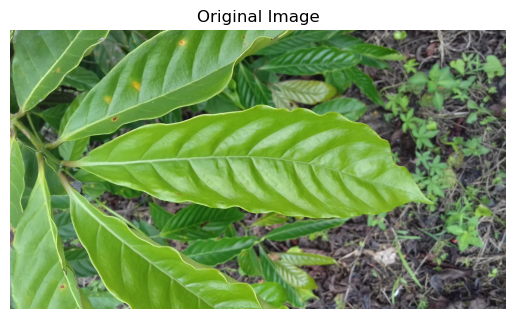

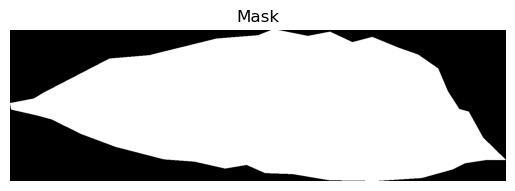

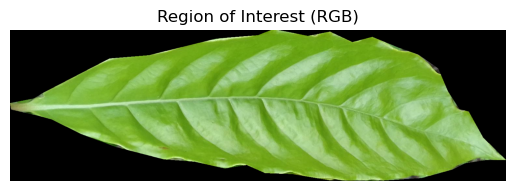

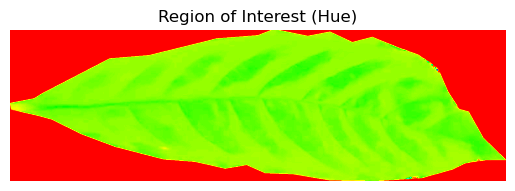

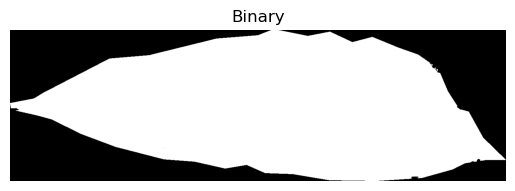

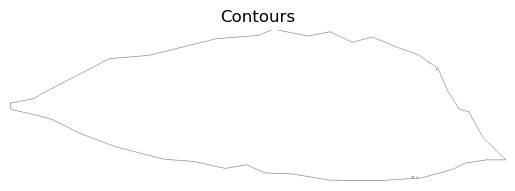

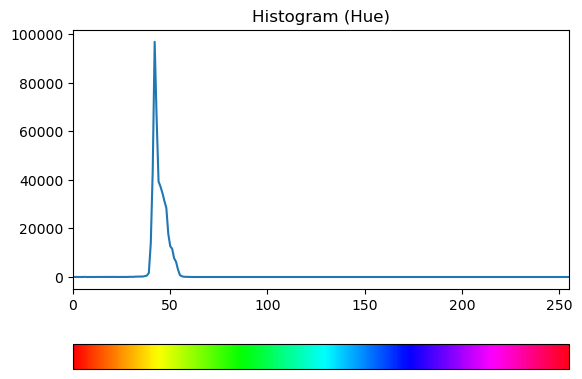

### rust_level_1 -> rust_level_1 (2.3159990809527455 %)

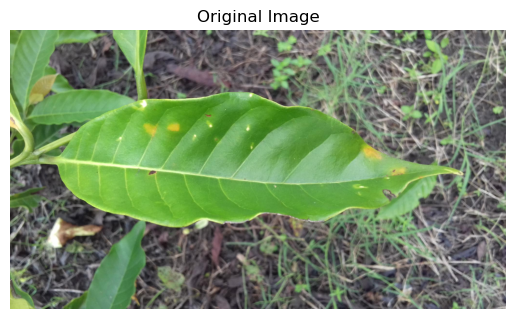

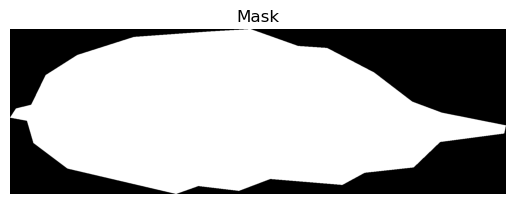

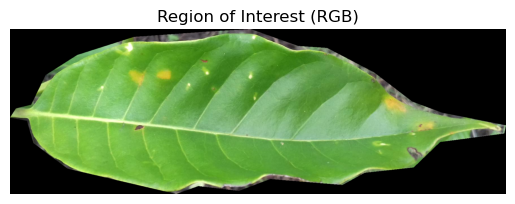

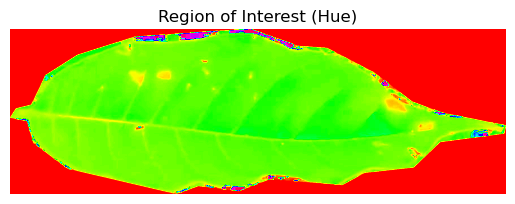

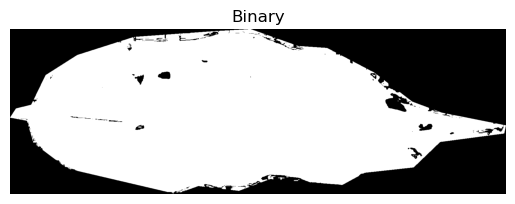

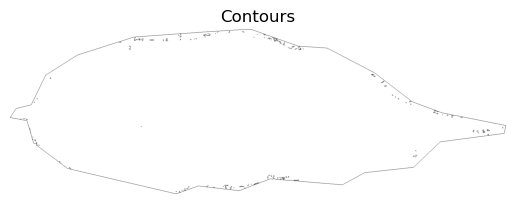

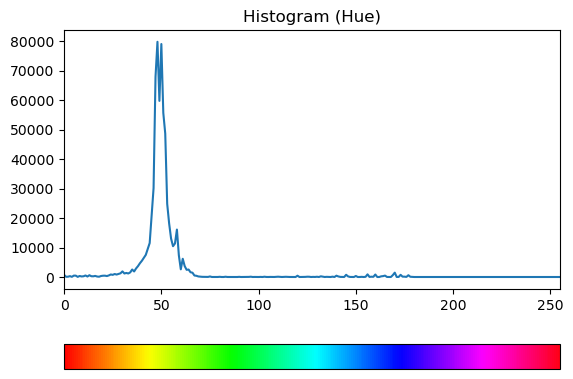

### rust_level_2 -> rust_level_2 (9.082992284200287 %)

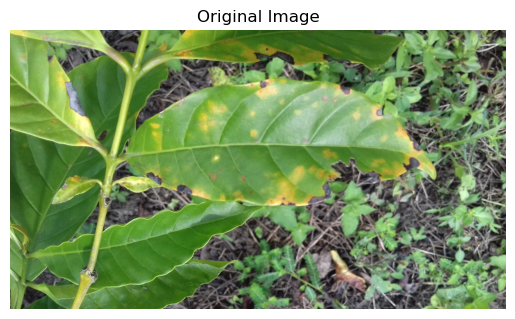

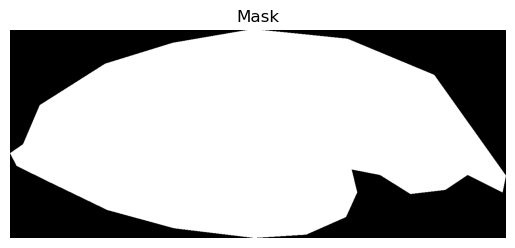

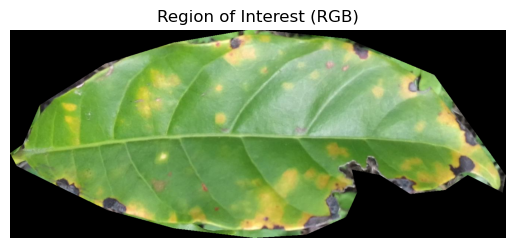

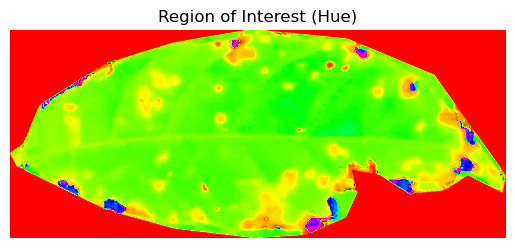

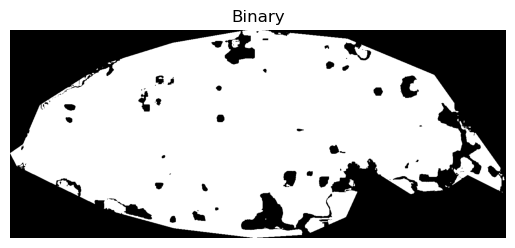

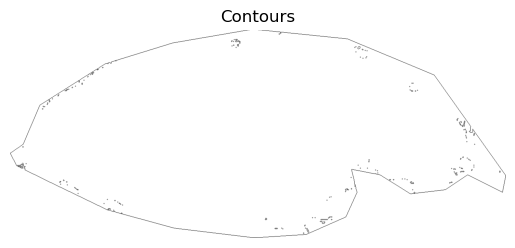

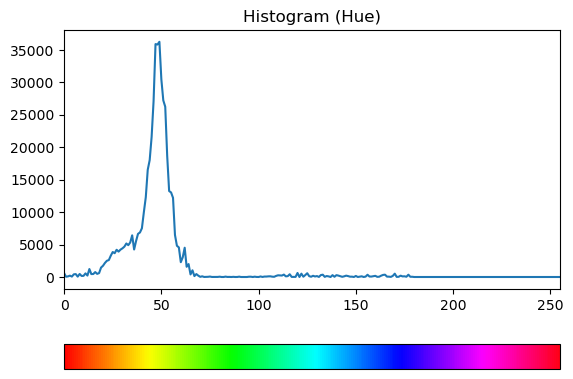

### rust_level_3 -> rust_level_2 (10.425740326294964 %)

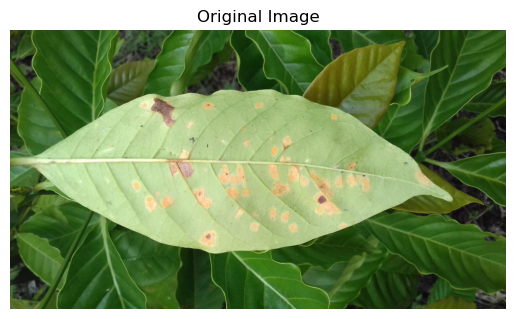

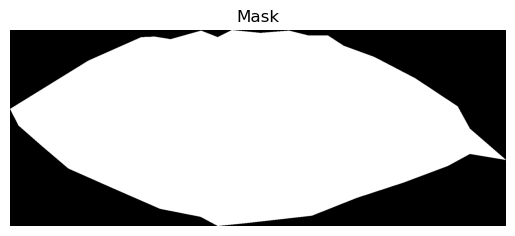

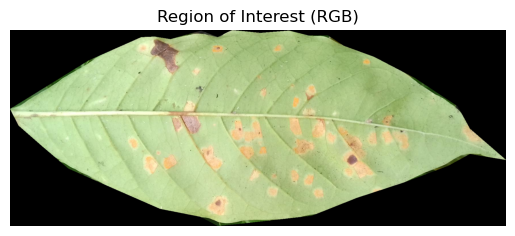

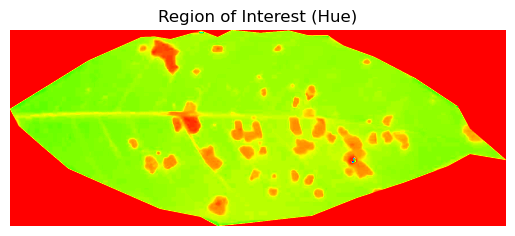

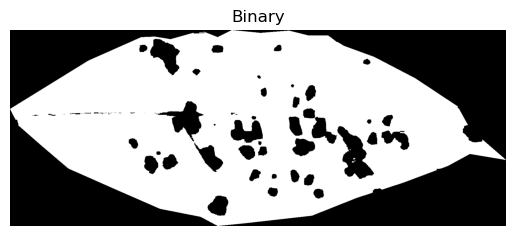

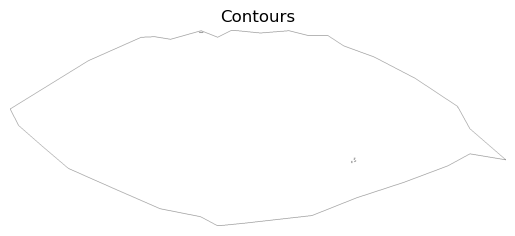

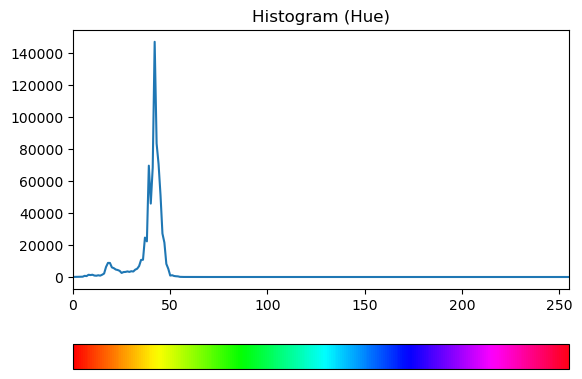

### rust_level_4 -> rust_level_2 (8.047620851644188 %)

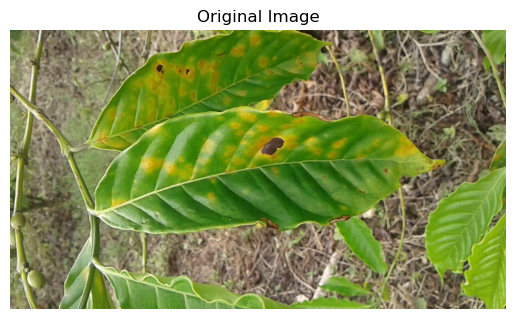

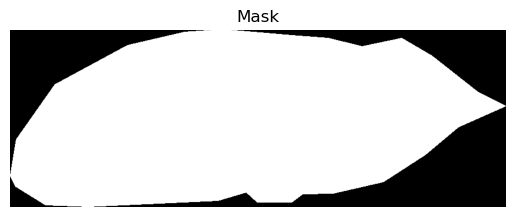

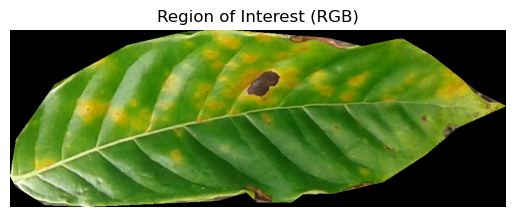

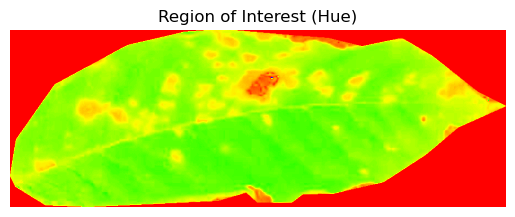

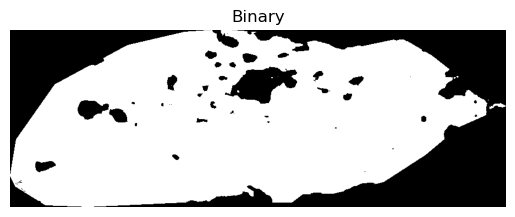

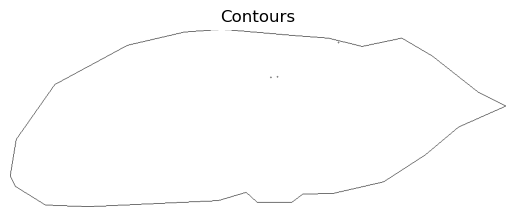

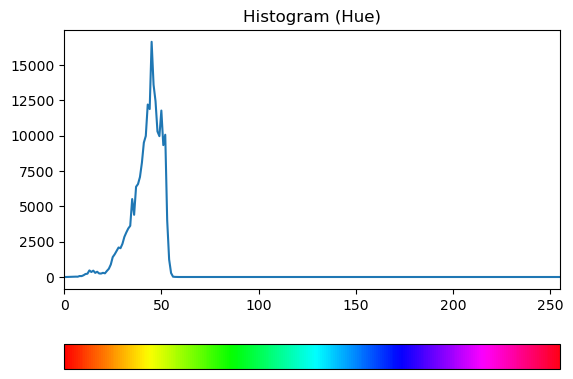

### red_spider_mite -> rust_level_2 (6.196155978761164 %)

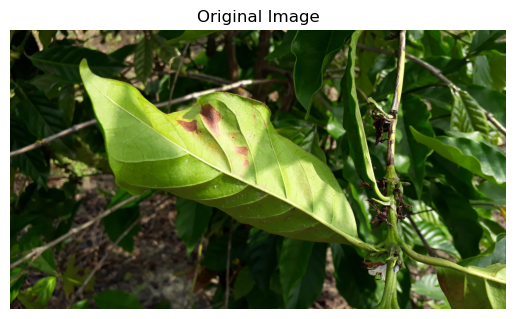

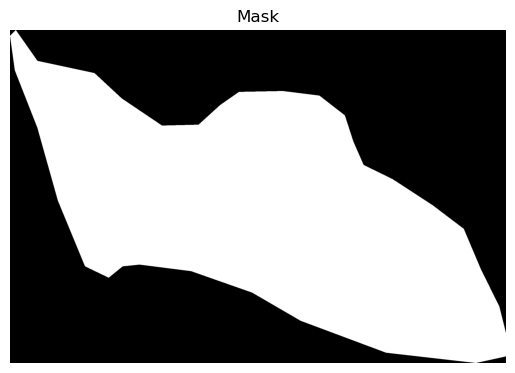

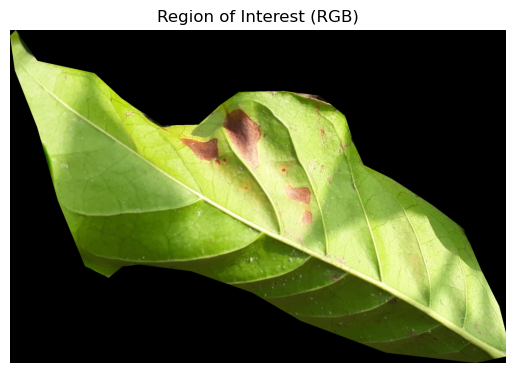

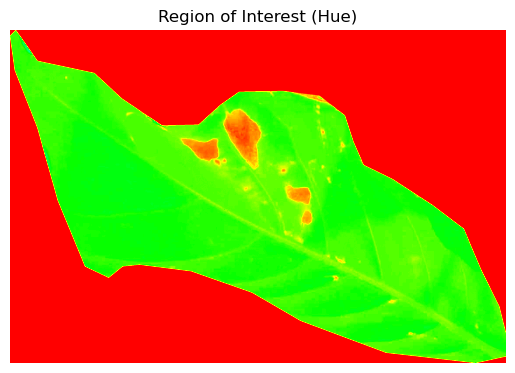

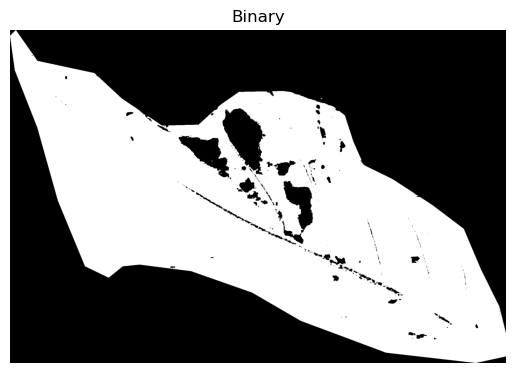

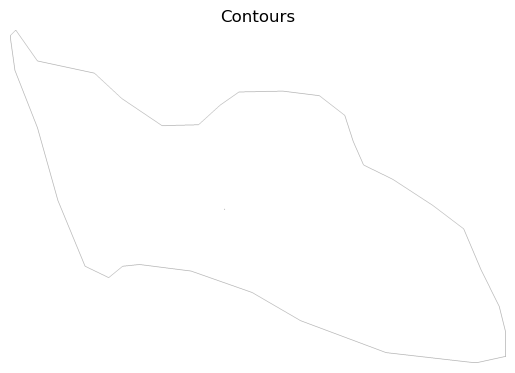

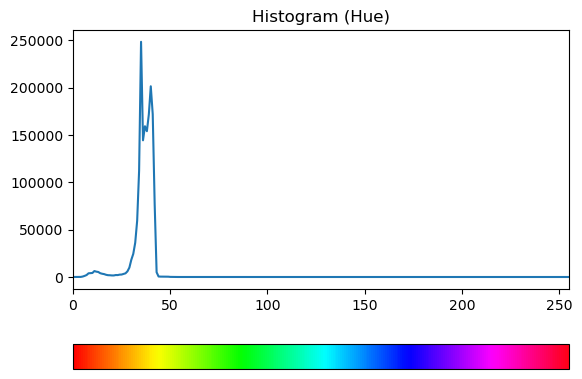

In [7]:
from IPython.display import display, Markdown

for coffee_leaf in coffee_leaves:
    original_class = coffee_leaf.classification_manual
    computed_class = coffee_leaf.classification_computed
    title_md = f"### {original_class} -> {computed_class} ({coffee_leaf.affected_percentage} %)"
    display(Markdown(title_md))
    coffee_leaf.describe()

## TODO:

* Erode -> Dilate to discard leaf skeleton
* Find contours in binary since theay should be holes
* Consider the high red part (values greater than 230)

## Resultados

In [8]:
healthy_original = [coffee_leaf.state_manual for coffee_leaf in coffee_leaves].count("healthy")
unhealthy_original = len(coffee_leaves)-healthy_original

healthy_computed = [coffee_leaf.state_computed for coffee_leaf in coffee_leaves].count("healthy")
unhealthy_computed = len(coffee_leaves)-healthy_computed

original_healthy = []
original_rust_level_1 = []
original_rust_level_2 = []
original_rust_level_3 = []
original_rust_level_4 = []
original_red_spider_mite = []

computed_healthy = []
computed_rust_level_1 = []
computed_rust_level_2 = []
computed_rust_level_3 = []
computed_rust_level_4 = []
computed_red_spider_mite = []

for coffee_leaf in coffee_leaves:
    if coffee_leaf.classification_manual == "healthy":
        original_healthy.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_1":
        original_rust_level_1.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_2":
        original_rust_level_2.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_3":
        original_rust_level_3.append(coffee_leaf)
    elif coffee_leaf.classification_manual == "rust_level_4":
        original_rust_level_4.append(coffee_leaf)
    else:
        original_red_spider_mite.append(coffee_leaf)

    if coffee_leaf.classification_computed == "rust_level_1":
        computed_rust_level_1.append(coffee_leaf)
    elif coffee_leaf.classification_computed == "rust_level_2":
        computed_rust_level_2.append(coffee_leaf)
    elif coffee_leaf.classification_computed == "rust_level_3":
        computed_rust_level_3.append(coffee_leaf)
    elif coffee_leaf.classification_computed == "rust_level_4":
        computed_rust_level_4.append(coffee_leaf)
    else:
        computed_healthy.append(coffee_leaf)

In [9]:
print("ORIGINAL:\n")
print(f"healthy: {len(original_healthy)}")
print(f"rust_level_1: {len(original_rust_level_1)}")
print(f"rust_level_2: {len(original_rust_level_2)}")
print(f"rust_level_3: {len(original_rust_level_3)}")
print(f"rust_level_4: {len(original_rust_level_4)}")
print(f"red_spider_mite: {len(original_red_spider_mite)}")

print("\nCOMPUTED:\n")
print(f"healthy: {len(computed_healthy)}")
print(f"rust_level_1: {len(computed_rust_level_1)}")
print(f"rust_level_2: {len(computed_rust_level_2)}")
print(f"rust_level_3: {len(computed_rust_level_3)}")
print(f"rust_level_4: {len(computed_rust_level_4)}")
print(f"red_spider_mite: {len(computed_red_spider_mite)}")

ORIGINAL:

healthy: 1
rust_level_1: 1
rust_level_2: 1
rust_level_3: 1
rust_level_4: 1
red_spider_mite: 1

COMPUTED:

healthy: 1
rust_level_1: 1
rust_level_2: 4
rust_level_3: 0
rust_level_4: 0
red_spider_mite: 0
